# Rivulet: U. S. Geological Survey Water Quality APIs
_by Michelle H Wilkerson_

## Purpose of this Notebook

This notebook was developed as part of NSF Grant 2445609 to support accessing and processing public data for middle and high school classroom activities. It's written to be relatively accessible to beginners, but if you have not interacted with computational notebooks or python before you may find navigating this tool difficult. (Check out the Show Your Work project for a gentle introduction to computational notebooks for educators!)

Our project is focused on supporting data analysis and mechanistic reasoning in science education. In other words, we want students to learn how data provides information about _how scientific mechanisms work_, and how understanding scientific mechanisms can help them to _explain and interpret patterns in data_. This builds on a long history of research on complex systems and agent-based modeling, and more closely connects that work to current expansions of data analysis across subjects.

Here, we are focused on Water Quality as a phenomenon. While most students understand that poor Water Quality can impact health, they may not know what sorts of pollutants impact water quality, and what kinds of events or conditions lead to reductions in water quality.

This data tool allows users to connect to the United States Geological Survey (USGS) water data APIs, search for water quality data streams in an area of interest, and then provides a collection of ways to fitler and search the data to ensure you find datasets that have patterns worth exploring. These kinds of datasets can serve as a launch to examining what WQ is and what are its underlying mechanistic and compositional complexities.

You are welcome to modify and adapt this script. You may find the USGS' water data APIs documentation [here]() and [here](https://doi-usgs.github.io/dataretrieval-python/) helpful.

## Part 0: What is an API? (Click to expand...)

Describe APIs, how they work, how common they are in data science, why they are useful for educators and educational researchers who do data science education work to know about. Describe the risks and concerns about APIs and using them to source data that students will interact with.

## Part I: Connecting with USGS Water Data APIs

The USGS has developed a python library (unhelpfully but impressively called `dataretrieval`) to help people access and fetch hydrological data from several different water-related data services.

You can sign up for an API key [at this site](https://api.waterdata.usgs.gov/signup). Once you recieve it, replace the DEMO_KEY below with your unique API key. Do not share your key!

In [ ]:
!pip install dataretrieval

API_KEY = "DEMO_KEY" 

Not sure this is important yet, but the docs say that if you want data after March 2024 you want to specify `legacy=False`. See [here](https://github.com/DOI-USGS/dataretrieval-python#:~:text=%E2%9A%A0%EF%B8%8F,the%20wqp%20module.) and [here](https://doi-usgs.github.io/dataRetrieval/articles/Status.html#:~:text=Discrete%20Data,non%2DUSGS%20data) for more information.

In [2]:
import dataretrieval.nwis as nwis
import pandas as pd

## Part 2: Specifying a Location and Time Period

Let's create a bounding box to indicate the region we are interested in. We will then filter our queries to focus only on monitoring sites within the bounding box.

In [3]:
# EDIT HERE: Define a bounding box around your
# target region. If it is densely populated, we suggest
# you start with a bounding box that is only one degree
# in area. 

min_lat = 37.5 # CHANGE TO YOUR MINIMUM LATITUDE
max_lat = 38 # CHANGE TO YOUR MAXIMUM LATITUDE

min_long = -122.5 # CHANGE TO YOUR MINIMUM LONGITUDE
max_long = -122

# this is unnecessary but sort of luxurious. let's map the box to
# make sure we're capturing what we want.

import folium

bbox = [[min_lat, min_long], [max_lat, max_long]]

# Calculate the center of the box to position the map
map_center = [(bbox[0][0] + bbox[1][0]) / 2, (bbox[0][1] + bbox[1][1]) / 2]

# Create a Folium map object
m = folium.Map(location=map_center, zoom_start=8)

# Add a rectangle for the bounding box to the map
folium.Rectangle(
    bounds=bbox,
    color="#ff0000",        # Red border
    fill=True,
    fill_color="#ff7800",   # Orange fill
    fill_opacity=0.2
).add_to(m)

m

We're gonna fetch the list of sites within the specified bounding box above. 

Like the AQS team, the NWIS team is awesome and fetch you some beautiful data. For each request, they pass back a tuple (in this case, a two-ple) of dataframe, metadata. So be sure you catch what's returned with that format. Below, since we are requesting sites, we assign the results of the request to the tuple sites, sites_metadata.

Note that at the bottom of the output here, you'll get a URL. That's the corresponding GET request that you can put in to get the same data. Helpful for debugging if something's not working as you would expect.

In [4]:
# bBox (list): A contiguous range of decimal latitude and longitude.
# Starts with the west longitude, then the south latitude, 
# then the east longitude, and then the north latitude 
# with each value separated by a comma. 
# The product of the range of latitude range and longitude cannot exceed 25 degrees. 
# TODO: Ok I have no idea how to smartly translate from the idea of min/max 
# (especially considering different hemispheres) to this idea of east west. 
# Since these are US Services maybe we can ignore the hemisphere question for now...

bbox = str(min_long) + "," + str(min_lat) + "," + str(max_long) + "," + str(max_lat)

Whoa! Ok that's a lot of sites. Depending on the phenomena we're interested in, we'll filter this to only what we need.

Next, we want to identify a date when we think something interesting is happening (or, a date we're interested in for other reasons). California experienced king tides during Jan 11-13 this year, so let's identify Jan 12 as a target date. 

Below, we set the target date. We'll use this to see which monitoring stations were active at the time of interest.

In [5]:
# EDIT HERE: identify a target date when something interesting
# was happening. Below, I define Jan 12, 2025, during king tides in CA.

from datetime import datetime, timedelta

target_date = "11-11-2024"
target_datetime = datetime.strptime(target_date, "%m-%d-%Y")

start_date = target_datetime
end_date = target_datetime + timedelta(days=1)

The function what_sites() allows us to see which sites were active and recording the things we're interested in during our specified date. Let's use this to filter our list. You can also filter by what's being measured, see the list in [USGS parameter codes](https://help.waterdata.usgs.gov/parameter_cd?group_cd=PHY). There are a ton of different salinity parameters, so let's just look at the ones that the USGS and EPA agree on (and are checked for accuracy):

## Part 3: Salinity in Estuaries

This first section helps you select datasets that feature information about salinity, in bodies of water where salinity behaves in interesting ways. This includes in estuaries where fresh and salt water meet, and in cold areas during winter months, when salt road treatments run off into freshwater sources. 

These patterns connect to inflection points and understanding tidal dynamics at the interface or fresh and salt water, as the tides flow in and out.

Here's the deal. Salinity is measured through conductance. So in NWIS there are a ton of salinity measures but the best one to look for is "specific conductance", which is a measure of salinity that is also adjusted for temperature. 

In [6]:
estuaries, estuaries_metadata = nwis.what_sites(bBox=bbox,
                                        startDt=start_date,
                                        endDt=end_date,
                                        parameterCd='00095',
                                        siteType='ES') #estuaries

estuaries

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,geometry
0,USGS,11162690,SAN FRANCISCO BAY A PRESIDIO MILITARY RSERV CA,ES,37.806595,-122.457750,F,NAD83,NaN,NaN,NaN,18050002,POINT (-122.45775 37.8066)
1,USGS,11162700,SAN FRANCISCO BAY A PIER 24 A SAN FRANCISCO CA,ES,37.790762,-122.385804,F,NAD83,NaN,NaN,NaN,18050004,POINT (-122.3858 37.79076)
2,USGS,11162765,SF BAY A SAN MATEO BRIDGE NR FOSTER CITY CA,ES,37.584379,-122.250800,F,NAD83,NaN,NaN,NaN,18050004,POINT (-122.2508 37.58438)
3,USGS,11181360,SAN PABLO STRAIT A PT SAN PABLO CA,ES,37.964646,-122.429417,F,NAD83,NaN,NaN,NaN,18050002,POINT (-122.42942 37.96465)
4,USGS,373015122071000,SOUTH SAN FRANCISCO BAY AT DUMBARTON BRIDGE CA,ES,37.504104,-122.120519,S,NAD83,30.0,10.0,NGVD29,18050004,POINT (-122.12052 37.5041)
5,USGS,373318122113001,SAN FRANCISCO BAY A REDWOOD PT CA,ES,37.554935,-122.192743,U,NAD83,NaN,NaN,NaN,18050004,POINT (-122.19274 37.55494)
6,USGS,373600122161201,SAN FRANCISCO BAY A SAN MATEO BRIDGE CA,ES,37.599934,-122.271079,U,NAD83,NaN,NaN,NaN,18050004,POINT (-122.27108 37.59993)
7,USGS,373642122120401,SAN FRANCISCO BAY 0.57 MI N OF SAN MATEO BRIDG...,ES,37.611739,-122.201200,H,NAD83,0.0,4.3,NAVD88,18050004,POINT (-122.2012 37.61174)
8,USGS,373751122143601,SAN FRANCISCO BAY 2.8 MI N OF SAN MATEO BRIDGE CA,ES,37.630789,-122.243200,5,NAD83,0.0,4.3,NAVD88,18050004,POINT (-122.2432 37.63079)
9,USGS,374018122193001,SAN FRANCISCO BAY A OYSTER PT CA,ES,37.671599,-122.326081,U,NAD83,NaN,NaN,NaN,18050004,POINT (-122.32608 37.6716)


Many sites that have been returned in my tests of this code that have this parameter as a column, but only have NaN values. That's frustrating. This seems to correspond to records that have NaNs in the alt_datum_cd column, though eventually someone should come back and check this more thoroughly. For me, now, it's a heuristic based on my eyeballing and playing with SF Bay Area data only.

In [7]:
estuaries = estuaries[~estuaries['alt_datum_cd'].isna()]

estuaries

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,geometry
4,USGS,373015122071000,SOUTH SAN FRANCISCO BAY AT DUMBARTON BRIDGE CA,ES,37.504104,-122.120519,S,NAD83,30.0,10.0,NGVD29,18050004,POINT (-122.12052 37.5041)
7,USGS,373642122120401,SAN FRANCISCO BAY 0.57 MI N OF SAN MATEO BRIDG...,ES,37.611739,-122.201200,H,NAD83,0.0,4.3,NAVD88,18050004,POINT (-122.2012 37.61174)
8,USGS,373751122143601,SAN FRANCISCO BAY 2.8 MI N OF SAN MATEO BRIDGE CA,ES,37.630789,-122.243200,5,NAD83,0.0,4.3,NAVD88,18050004,POINT (-122.2432 37.63079)
13,USGS,374811122235001,SAN FRANCISCO BAY A PIER 17 A SAN FRANCISCO CA,ES,37.803050,-122.397308,1,NAD83,0.0,10.0,NGVD29,18050002,POINT (-122.39731 37.80305)
14,USGS,374816122271501,CRISSY MARSH A SAN FRANCISCO CA,ES,37.804444,-122.454167,U,NAD83,10.0,12.0,NGVD29,18050002,POINT (-122.45417 37.80444)
16,USGS,374938122251801,SAN FRANCISCO BAY A NE SHORE ALCATRAZ ISLAND CA,ES,37.827222,-122.421667,S,NAD83,12.0,12.0,NGVD29,18050002,POINT (-122.42167 37.82722)
20,USGS,375607122264701,SAN FRANCISCO BAY A RICHMOND-SAN RAFAEL BRIDGE CA,ES,37.935278,-122.446389,S,NAD83,0.0,10.0,NGVD29,18050002,POINT (-122.44639 37.93528)


YAAS! Ok, for the estuaries, we'll want to see the flows in and out, so we want maybe a week or two of data around the target date. Pick your favorite site from the list above, and plop it into the code below to pull the specific conductance data.

In [8]:
# reset our start and end time to a period of 2 weeks surrounding the target date
start_date = target_datetime - timedelta(days=4)
end_date = target_datetime + timedelta(days=4)

# ones that work 374722122155501
# 373015122071000

sal_data, meta = nwis.get_iv(sites='373015122071000', #site of your choice 
                           parameterCd='00095',
                           start=start_date.strftime("%Y-%m-%d"),
                           end=end_date.strftime("%Y-%m-%d"))



In [9]:
sal_data

,site_no,00095_upper: 25 ft from bed,00095_upper: 25 ft from bed_cd,00095_lower: 4 ft from bed,00095_lower: 4 ft from bed_cd
datetime,,,,,
2024-11-07 08:00:00+00:00,373015122071000,43600.0,P,44700.0,P
2024-11-07 08:15:00+00:00,373015122071000,43800.0,P,44800.0,P
2024-11-07 08:30:00+00:00,373015122071000,43800.0,P,44800.0,P
2024-11-07 08:45:00+00:00,373015122071000,44200.0,P,45100.0,P
2024-11-07 09:00:00+00:00,373015122071000,44400.0,P,45300.0,P
...,...,...,...,...,...
2024-11-16 06:45:00+00:00,373015122071000,NaN,NaN,45400.0,P
2024-11-16 07:00:00+00:00,373015122071000,NaN,NaN,45800.0,P
2024-11-16 07:15:00+00:00,373015122071000,NaN,NaN,46000.0,P


Plot it to be sure we see what we think we'll see

<Axes: xlabel='datetime', ylabel='00095_upper: 25 ft from bed'>

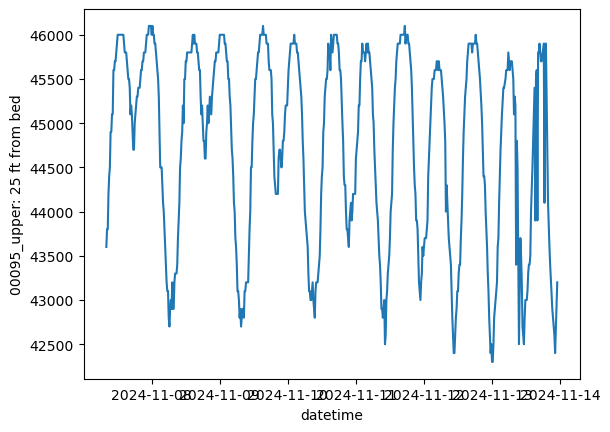

In [10]:
import seaborn as sns

sns.lineplot(data=sal_data,x='datetime', y='00095_upper: 25 ft from bed')

Now we have a list of only estuaries. Let's filter so that we're only looking at estuaries that 

## Part 4: EColi

Ecoli problems occur in water sources after rains, when sewers release bacteria. Let's check it out. Remember that you define your location bounding box and your target date in Part 2 setup above. Go up and reset these if you have been working through the notebook in order, to identify a time close to a rain, perhaps after a dry spell.

For SF Bay area, we're going to look for creeks. We're going to use the target date of Sept 9 because I remember that's when I got all wet biking to campus :)

In [8]:
### eventually clean this up so target date is taken care of in 
# the setup section only but for now I'm just going
# to do it here
target_date = "01-04-2023"
target_datetime = datetime.strptime(target_date, "%m-%d-%Y")

start_date = target_datetime
end_date = target_datetime + timedelta(days=1)
## end cleanup section

# check the parameter here, I went for one that was there and made sense
ecoli_data, ec_meta = nwis.what_sites(bBox=bbox,
                                      startDt=start_date,
                                      endDt=end_date,
                                      parameterCd='31625')#, #fecal coliforms
                                    #  siteType='ST') #streams

ecoli_data

,agency_cd,site_no,station_nm,site_tp_cd,dec_lat_va,dec_long_va,coord_acy_cd,dec_coord_datum_cd,alt_va,alt_acy_va,alt_datum_cd,huc_cd,geometry
0,USGS,11181330,TEMESCAL C AB LK TEMESCAL A OAKLAND CA,ST,37.843815,-122.227468,F,NAD83,NaN,NaN,NaN,18050002,POINT (-122.22747 37.84382)
1,USGS,11181335,CALDECOTT C A LK TEMESCAL AT OAKLAND CA,ST,37.846593,-122.228857,F,NAD83,NaN,NaN,NaN,18050002,POINT (-122.22886 37.84659)
2,USGS,375002122124801,TEMESCAL C A GRISBORNE AVE AT OAKLAND CA,ST,37.833816,-122.214412,U,NAD83,NaN,NaN,NaN,18050002,POINT (-122.21441 37.83382)
3,USGS,375030122120801,TEMESCAL C BL HTHR RDG SWM POL A OAKLAND CA,ST,37.841593,-122.203301,U,NAD83,NaN,NaN,NaN,18050002,POINT (-122.2033 37.84159)
4,USGS,375030122122701,TEMESCAL C A THORNHILL B AT OAKLAND CA,ST,37.841593,-122.208579,U,NAD83,NaN,NaN,NaN,18050002,POINT (-122.20858 37.84159)
5,USGS,375031122122701,TEMESCAL C A PINEHAVEN B AT OAKLAND CA,ST,37.841871,-122.208579,U,NAD83,NaN,NaN,NaN,18050002,POINT (-122.20858 37.84187)
6,USGS,375032122121301,TEMESCAL C A HEATHER RIDGE S AT OAKLAND CA,ST,37.842149,-122.204690,U,NAD83,NaN,NaN,NaN,18050002,POINT (-122.20469 37.84215)
7,USGS,375033122121201,TEMESCAL C A HEATHER RIDGE E AT OAKLAND CA,ST,37.842426,-122.204412,U,NAD83,NaN,NaN,NaN,18050002,POINT (-122.20441 37.84243)
8,USGS,375038122115101,TEMESCAL C A 8 ACRE CONTROL AT OAKLAND CA,ST,37.843815,-122.198578,U,NAD83,NaN,NaN,NaN,18050002,POINT (-122.19858 37.84382)
9,USGS,375039122133701,TEMESCAL C AB HOLDING POND A OAKLAND CA,ST,37.844093,-122.228024,U,NAD83,NaN,NaN,NaN,18050002,POINT (-122.22802 37.84409)


Ok just FYI you can search for body parts as an attribute that's available for what's in the water.

Note that for e coli data, we use a different module from the one we used in section 3 estuaries. Here, we use a module called WQP. More info [here]('https://code.usgs.gov/water/dataretrieval-python/-/blob/v1.0.2/dataretrieval/wqp.py')

In [ ]:
#about a week surrounding target date
start_date = target_datetime - timedelta(days=3)
end_date = target_datetime + timedelta(days=3)

from dataretrieval import wqp

ec_data, ecmeta = wqp.get_results(siteid='11181330', #site of your choice 
                           pCode='31625,50468,90901',
                           startDateLo=start_date.strftime("%m-%d-%Y"),
                           startDateHi=end_date.strftime("%m-%d-%Y"))

ec_data

#50468	E. coli, modified m-TEC method	Most Probable Number per 100 mL (MPN/100 mL)
#90901	E. coli, unspecified method	Colonies per 100 mL (cfu/100 mL)
#31633	E. coli, m-TEC MF method	Colony Forming Units per 100 mL (cfu/100 mL)
#31648	E. coli, m-TEC MF method	Colonies per 100 mL (cfu/100 mL)

E Coli is most likely to be found the sites most likely to show dramatic increases in E. coli after a rain event are smaller, fast-reacting bodies of water in watersheds with significant sources of fecal contamination. These are often called "flashy" systems.

in order of likelihood of a dramatic effect, check out sites that are:
- storm drains
- urban creeks and streams
- coastal beaches and river mouths
- small lakes

## Part 5: Oxygen Dissolution

## Part 6: Nitrates

## Part 7: Lead

## Credits

We are grateful to Dr. Lex Van Geen for his insights into pedagogically productive datasets.

Hodson, T.O., Hariharan, J.A., Black, S., and Horsburgh, J.S., 2023, dataretrieval (Python): a Python package for discovering and retrieving water data available from U.S. federal hydrologic web services: U.S. Geological Survey software release, https://doi.org/10.5066/P94I5TX3.